### reqs

import pandas, prophet

In [3]:
# pandas
import pandas as pd

# prophet
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

# utils
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split

# matplotlib
%matplotlib inline
import matplotlib
plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]
matplotlib.rcParams['figure.facecolor'] = 'white'

### load data

loads from data/observations.pickle

                            airtemp  cloudcover  precip  watertemp
2008-01-01 06:15:00+00:00 -7.274530    2.741197     0.0   1.943590
2008-01-01 06:30:00+00:00 -7.352735    2.464017     0.0   1.918974
2008-01-01 06:45:00+00:00 -7.365834    2.229257     0.0   1.895998
2008-01-01 07:00:00+00:00 -7.319631    2.035260     0.0   1.874504
2008-01-01 07:15:00+00:00 -7.219930    1.880372     0.0   1.854337


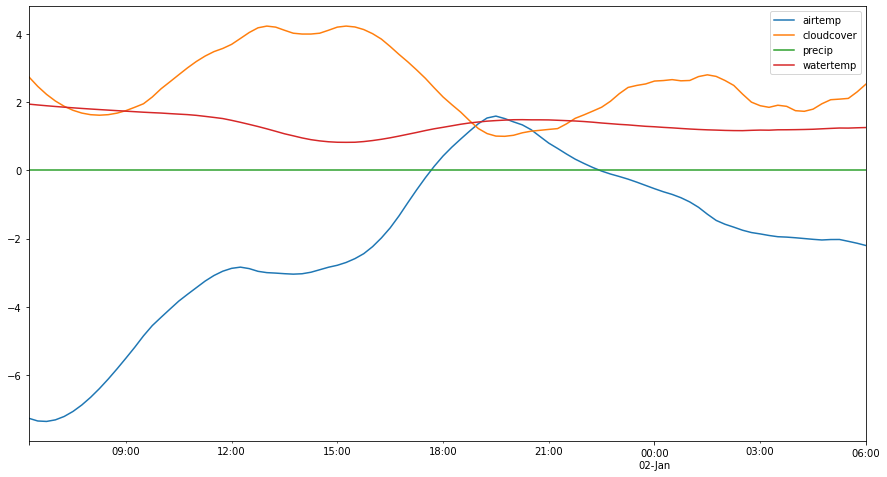

In [4]:
observations = pd.read_pickle('output/observations.pickle')

# to make this data better suited for regression, we'll run it through savitzky golay to smooth
observations = observations.apply(lambda d: savgol_filter(d, 25, 3))

# for readability, rename 107337_00065 -> gageheight, 107338_00010 -> watertemp
observations = observations.rename(columns={'107337_00065': 'gageheight', '107338_00010': 'watertemp'})

# [temp] to simplify, drop gageheight and reduce num observations
observations = observations.drop(columns=['gageheight'])
# observations = observations.head(4 * 24 * 365 * 4)

print(observations.head())
observations.head(4 * 24).plot()
plt.show()

In [5]:
# water temp -> y, index -> ds
observations = observations.reset_index()
observations = observations.rename(columns={'watertemp': 'y', 'index': 'ds'})

# remove timezone
observations['ds'] = observations['ds'].dt.tz_localize(None)

print(observations.head())

# split df
cutoff = int(observations.shape[0] * 0.80)
train = observations.iloc[:cutoff, :]
test = observations.iloc[cutoff:, :]

print(train.shape, test.shape)

                   ds   airtemp  cloudcover  precip         y
0 2008-01-01 06:15:00 -7.274530    2.741197     0.0  1.943590
1 2008-01-01 06:30:00 -7.352735    2.464017     0.0  1.918974
2 2008-01-01 06:45:00 -7.365834    2.229257     0.0  1.895998
3 2008-01-01 07:00:00 -7.319631    2.035260     0.0  1.874504
4 2008-01-01 07:15:00 -7.219930    1.880372     0.0  1.854337
(390224, 5) (97556, 5)


### build model

In [6]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.add_regressor('airtemp', standardize=False)
model.add_regressor('cloudcover', standardize=False)
model.add_regressor('precip', standardize=False)

# fit
model.fit(train)

/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -25424.7


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.

      99        874952   0.000796825        178992           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        877682     0.0111749        431030      0.2254           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        882643    0.00221847        527191           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        883348   0.000394125        247686           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        885226     0.0289053        103525           1           1      645   
    Iter      log prob        ||dx||      |

/var/folders/b7/bvjyym4n5wl1lf69hry6ls1m0000gn/T/ipykernel_93043/228554614.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  week = train.tail(4 * 24 * 3).append(test.head(4 * 24 * 28))
/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/anaconda3/envs/prophet/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


                        ds    airtemp  cloudcover  precip         y
389936 2019-03-17 22:30:00  -1.149013    0.341604     0.0  3.201024
389937 2019-03-17 22:45:00  -1.461372    0.208232     0.0  3.139923
389938 2019-03-17 23:00:00  -1.759923    0.083092     0.0  3.080715
389939 2019-03-17 23:15:00  -2.043768   -0.012831     0.0  3.018415
389940 2019-03-17 23:30:00  -2.310164   -0.082164     0.0  2.955343
...                    ...        ...         ...     ...       ...
392907 2019-04-17 23:45:00  12.722023    1.211498     0.0  7.623034
392908 2019-04-18 00:00:00  12.322878    1.353894     0.0  7.629005
392909 2019-04-18 00:15:00  11.929523    1.479072     0.0  7.637295
392910 2019-04-18 00:30:00  11.560121    1.609739     0.0  7.647517
392911 2019-04-18 00:45:00  11.223291    1.743768     0.0  7.659285

[2976 rows x 5 columns]                       ds     trend  ...  multiplicative_terms_upper      yhat
0    2019-03-17 22:30:00  8.912207  ...                         0.0  2.808212
1  

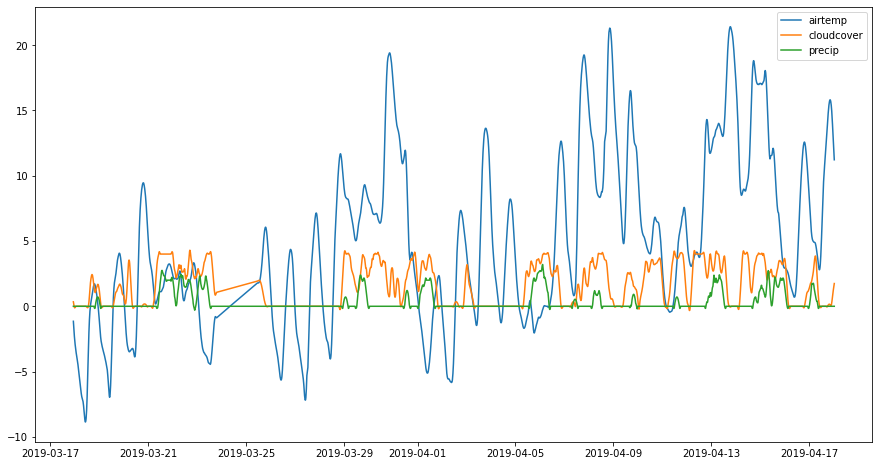

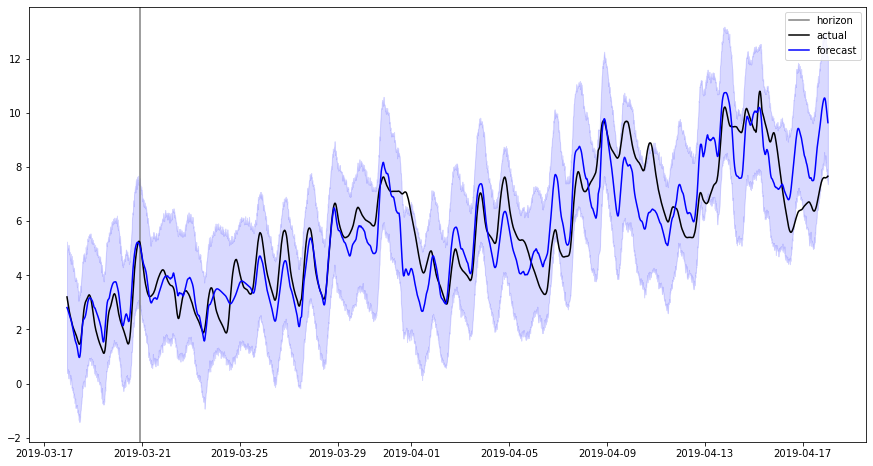

In [7]:
# forecast one week
week = train.tail(4 * 24 * 3).append(test.head(4 * 24 * 28))

# compare
actual = week

# # 3 days historical
# historical = week.iloc[:4 * 24 * 3, :]
# projected = week.iloc[4 * 24 * 3:, :][['ds', 'airtemp', 'cloudcover', 'precip']]
# combined = historical.append(projected)
# print(combined)

forecast = model.predict(week[['ds', 'airtemp', 'cloudcover', 'precip']])
predicted = forecast

print(actual, predicted)

# plot weather conditions
plt.plot(week['ds'], week['airtemp'])
plt.plot(week['ds'], week['cloudcover'])
plt.plot(week['ds'], week['precip'])
plt.legend(['airtemp', 'cloudcover', 'precip'])
plt.show()

# plot water temp forecast
plt.axvline(x=week['ds'].values[4 * 24 * 3], color='gray')
plt.plot(actual['ds'], actual['y'], color='black')
plt.plot(predicted['ds'], predicted['yhat'], color='blue')
plt.fill_between(predicted['ds'], predicted['yhat_lower'], predicted['yhat_upper'], color='blue', alpha=0.15)
plt.legend(['horizon', 'actual', 'forecast'])
plt.show()

### save model

In [8]:
with open('output/model.json', 'w+') as f:
  f.write(model_to_json(model))